In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from sklearn.metrics import mean_absolute_percentage_error

In [3]:
data_main = pd.read_csv('./Usage Data/EUI_and_Weather_cleaned.csv', engine='python')

In [4]:
data_main.head()

,Unnamed: 0,BLDG_UID,Building,Date,HDD_daily,CDD_daily,GHI_sum,Avg_Temp_Daily,Humidity_avg,Elec_Power,...,MAX_Floors,FSP_Classroom,FSP_Lab,FSP_Library,FSP_Office,BLDG_Height,GFA,GBA,DayOfYear,DayOfWeek
0,1,VBL10087,AERL,2012-01-02,11.291667,0.0,193,6.708333,81.985833,51.243222,...,6.0,0.06,0.05,0.0,0.46,19.33,5368.0,5731.0,2,2
1,2,VBL10087,AERL,2012-01-03,10.308333,0.0,109,7.691667,88.047917,58.502486,...,6.0,0.06,0.05,0.0,0.46,19.33,5368.0,5731.0,3,3
2,3,VBL10087,AERL,2012-01-04,9.450000,0.0,377,8.550000,85.631250,70.030504,...,6.0,0.06,0.05,0.0,0.46,19.33,5368.0,5731.0,4,4
3,4,VBL10087,AERL,2012-01-05,11.825000,0.0,509,6.175000,85.328333,69.011653,...,6.0,0.06,0.05,0.0,0.46,19.33,5368.0,5731.0,5,5
4,5,VBL10087,AERL,2012-01-06,13.891667,0.0,407,4.108333,86.571667,65.758433,...,6.0,0.06,0.05,0.0,0.46,19.33,5368.0,5731.0,6,6


In [41]:
# Ignore redundancy, used to calibrate NA values


Nsplit = 2919
sample_na_AERL = data_main[data_main['Building'] == 'AERL']
sample_na_AERL = sample_na_AERL.drop(sample_na_AERL.columns[9:16], axis=1)
train_na_AERL = sample_na_AERL.iloc[:Nsplit].dropna()
test_na_AERL = sample_na_AERL.iloc[Nsplit:].dropna()
sample_AERL = pd.concat([train_na_AERL, test_na_AERL], axis=0)
# sample_AERL[sample_AERL['Date'] == '2020-01-01']

# Train-test split
Ntest = 714
train_AERL = sample_AERL.iloc[:-Ntest]
test_AERL = sample_AERL.iloc[-Ntest:]

train_idx = sample_AERL.index <= train_AERL.index[-1]
test_idx = sample_AERL.index > train_AERL.index[-1]

len(train_AERL), len(test_AERL), sum(train_idx), sum(test_idx)
# len(train_na_AERL), len(test_na_AERL), len(sample_AERL)

(1236, 714, 1236, 714)

In [42]:
# Supervised dataset
series = sample_AERL['Total_EUI_excwtr'].to_numpy()

T = 10
X = []
Y = []

for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

X = np.array(X).reshape(-1, T)
Y = np.array(Y)
N = len(X)

print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (1940, 10) Y.shape (1940,)


In [43]:
# Second split

Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

len(Xtrain), len(Xtest)

(1226, 714)

In [44]:
# ANN

i = Input(shape = (T,))
x = Dense(32, activation = 'relu')(i)
x = Dense(1)(x)
model = Model(i, x)

In [45]:
model.compile(
    loss = 'mse',
    optimizer = 'adam',
    metrics = 'mae',
)

In [46]:
r = model.fit(
    Xtrain,
    Ytrain,
    epochs = 100,
    validation_data = (Xtest, Ytest)
)

Epoch 1/100
39/39 [==============================] - 1s 7ms/step - loss: 0.0064 - mae: 0.0617 - val_loss: 0.0050 - val_mae: 0.0520
Epoch 2/100
39/39 [==============================] - 0s 2ms/step - loss: 0.0032 - mae: 0.0427 - val_loss: 0.0038 - val_mae: 0.0439
Epoch 3/100
39/39 [==============================] - 0s 2ms/step - loss: 0.0031 - mae: 0.0421 - val_loss: 0.0036 - val_mae: 0.0429
Epoch 4/100
39/39 [==============================] - 0s 2ms/step - loss: 0.0028 - mae: 0.0399 - val_loss: 0.0034 - val_mae: 0.0419
Epoch 5/100
39/39 [==============================] - 0s 2ms/step - loss: 0.0028 - mae: 0.0401 - val_loss: 0.0033 - val_mae: 0.0415
Epoch 6/100
39/39 [==============================] - 0s 2ms/step - loss: 0.0027 - mae: 0.0387 - val_loss: 0.0033 - val_mae: 0.0416
Epoch 7/100
39/39 [==============================] - 0s 2ms/step - loss: 0.0026 - mae: 0.0387 - val_loss: 0.0033 - val_mae: 0.0412
Epoch 8/100
39/39 [==============================] - 0s 2ms/step - loss: 0.0026 - m

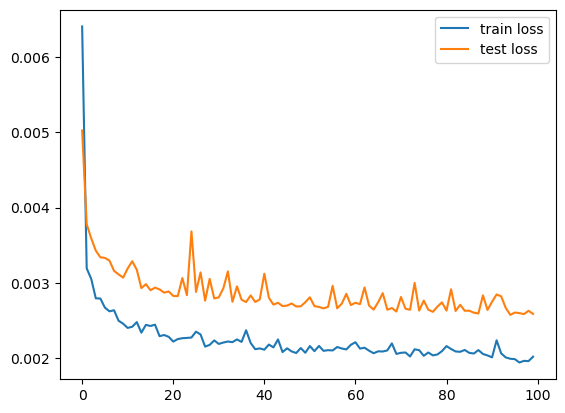

In [47]:
plt.plot(r.history['loss'], label = 'train loss')
plt.plot(r.history['val_loss'], label = 'test loss')
plt.legend();

In [48]:
train_idx[:T] = False
Ptrain = model.predict(Xtrain).flatten()
Ptest = model.predict(Xtest).flatten()

len(Ptrain), len(Ptest), sum(train_idx), sum(test_idx)

23/23 [==============================] - 0s 995us/step


(1226, 714, 1226, 714)

In [49]:
sample_AERL.loc[train_idx, 'ANN Training Set Prediction'] = Ptrain
sample_AERL.loc[test_idx, 'ANN Testing Set Prediction'] = Ptest

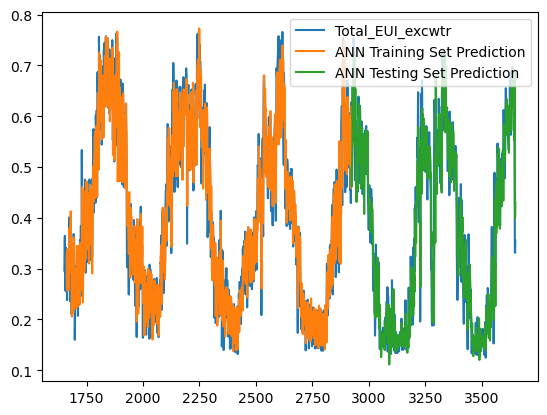

In [50]:
cols = ['Total_EUI_excwtr',
        'ANN Training Set Prediction',
        'ANN Testing Set Prediction']
sample_AERL[cols].plot();

In [51]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [52]:
y_pred = sample_AERL['ANN Testing Set Prediction'].dropna()
y_test = test_AERL['Total_EUI_excwtr']

len(y_pred), len(y_test)
MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
RMSE = MSE ** 0.5
R2 = r2_score(y_test, y_pred)

MAE, MSE, RMSE, R2

(0.03651743736676918,
 0.0025906090558301016,
 0.050898026050428535,
 0.9175344409270578)

<Axes: >

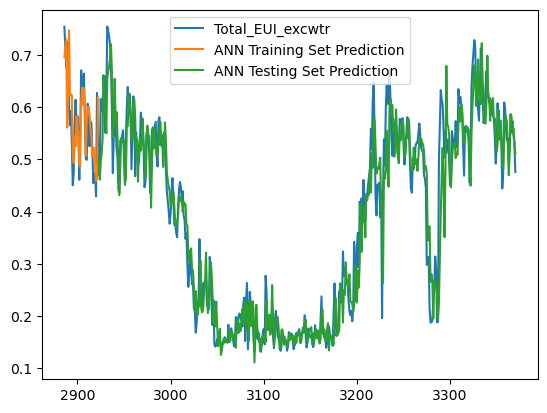

In [53]:
sample_AERL[cols][1200:1680].plot()

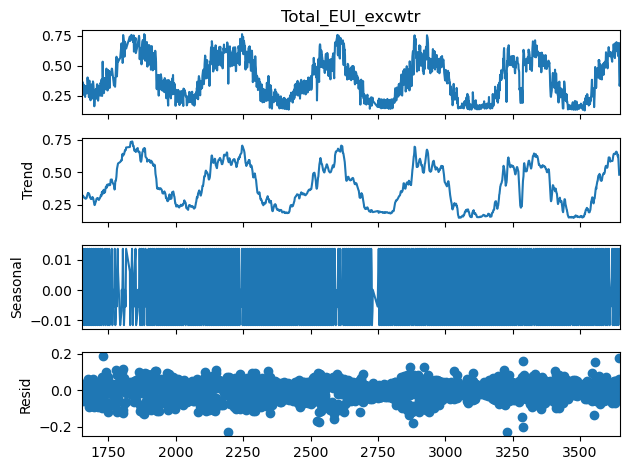

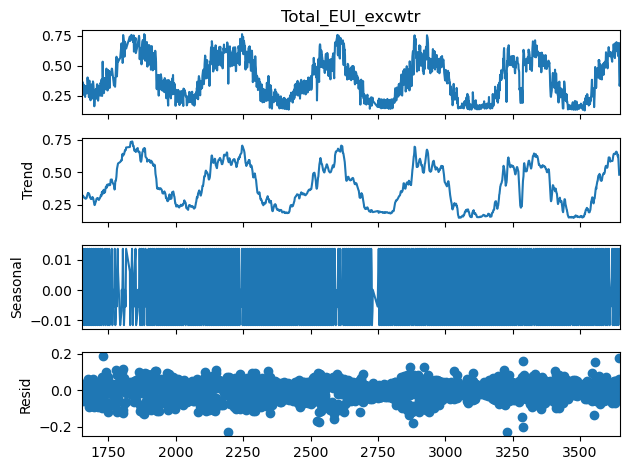

In [37]:
# SARIMAX BEGIN HERE

from statsmodels.tsa.seasonal import seasonal_decompose
AERL_decompose = seasonal_decompose(sample_AERL['Total_EUI_excwtr'], model="additive", period=7)
AERL_decompose.plot()

In [38]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(sample_AERL['Total_EUI_excwtr'], autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -3.010559768482992
2. P-Value :  0.03391994955263164
3. Num Of Lags :  23
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 1847
5. Critical Values :
	 1% :  -3.4338954312591943
	 5% :  -2.8631061094223527
	 10% :  -2.567603741659238
